# Real time evolution

Ising Hamiltonian time evolution is translated into a color map or a set of colors. Different options are possible.

In [ ]:
import numpy as np

from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import Pauli, SparsePauliOp

from qiskit_aer import AerSimulator

from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke,FakeTorino
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

import colorsys
import random

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

provider = QiskitRuntimeService()

In [ ]:
backend=FakeSherbrooke()
#backend=FakeTorino()
#backend = AerSimulator(method="matrix_product_state")

Hamiltonian: $H = \sum J_n * X_n X_{n+1} + \sum hz_n * Z_n + \sum hx_n * X_n$  with periodic condition

In [50]:
#INPUTS:
# Number of qubits
n_qubits = 2

dt = 0.1  ### time step
T =dt*50#3  ### total running time
J = 1
hz = 0.5
hx = -0.75

# Random or defined coupling coefficients
J_list = [J for _ in range(n_qubits) ]   # For Z_n Z_{n+1}
hz_list = [hz for _ in range(n_qubits) ]    # For Z_n
hx_list = [hx*(0.95+np.random.rand()*0.1) for _ in range(n_qubits) ]    # For X_n

hz_list[0] = 0
hx_list[0] = 0

In [51]:
# Build terms
pauli_terms = []
coeffs = []

# Z_n Z_{n+1} terms
for n in range(n_qubits - 1):
    z_pair = ['I'] * n_qubits
    z_pair[n] = 'X'
    z_pair[n + 1] = 'X'
    pauli_terms.append(''.join(z_pair))
    coeffs.append(J_list[n])

# Z_n terms
for n in range(n_qubits):
    z_term = ['I'] * n_qubits
    z_term[n] = 'Z'
    pauli_terms.append(''.join(z_term))
    coeffs.append(hz_list[n])

# X_n terms
for n in range(n_qubits):
    x_term = ['I'] * n_qubits
    x_term[n] = 'X'
    pauli_terms.append(''.join(x_term))
    coeffs.append(hx_list[n])

# Construct SparsePauliOp
hamiltonian = SparsePauliOp.from_list(list(zip(pauli_terms, coeffs)))

# Optional: Print for inspection
print(hamiltonian)


z_mag = ['I'] * n_qubits

identity = SparsePauliOp([''.join(z_mag)],coeffs=[1])

z_mag[-1] = 'Z' #The qubit 0 corresponds to -1
z_mag = ''.join(z_mag)
observable = SparsePauliOp([z_mag],coeffs=[1])


SparsePauliOp(['XX', 'ZI', 'IZ', 'XI', 'IX'],
              coeffs=[ 1.        +0.j,  0.        +0.j,  0.5       +0.j,  0.        +0.j,
 -0.73194989+0.j])


In [52]:
### Time evolution of the Ising model
def time_evolution_Ising(N:int, J_list:list, hz_list:list, hx_list:list, dt:float) -> QuantumCircuit:
    """Time evolution circuit for the Ising model with open boudary conditions: H = sum J_n * Z_n Z_{n+1} + sum h_n * Z_n + sum h_n * X_n
    Args:
        N: number of qubits
        J_list: interacting couplings for each nearest neighbor
        hz_list: interacting couplings for Z_n for each qubit
        hx_list: interacting couplings for X_n for each qubit
        dt: time step
    Returns:
        circ_dt: QuantumCircuit of the time evolution
    """

    q = QuantumRegister(N)
    circ_dt = QuantumCircuit(q)

    ## \PI_n exp(-it * J[n] * Z_n Z_{n+1})
    # n_eo_list: the orders for the two qubits gates, run the two-qubit gates of (n, n+1) for all even n in parallel; then  run the gates of (n, n+1) for all odd n
    n_eo_list = list(range(0, N-((N+1)%2), 2)) + list(range(1, N-(N%2), 2))
    for n in n_eo_list:
        circ_dt.rxx(2*dt*J_list[n],q[n], q[(n+1)%N])

    ## \PI_n exp(-it * hx[n] * X_n) exp(-it * hz[n] * Z_n)
    for n in range(N):
        circ_dt.rz(2*dt*hz_list[n], q[n])
        circ_dt.rx(2*dt*hx_list[n], q[n])

    # k = 0
    # for i in range(N):
    #     for j in range(i+1, N):
    #         circ_dt.cx(q[i], q[j])
    #         circ_dt.rz(2*dt*J_list[k], q[j])
    #         circ_dt.cx(q[i], q[j])
    #         k+=1


    return circ_dt



#### Run time evolution (now on a fake IBM device FakeTorino)

In [53]:
# Backend
estimator = Estimator(backend)


circuits=[]
circ = QuantumCircuit(n_qubits)
circ.ry(theta=2.5,qubit=0)
circ.rz(phi=2.5,qubit=0)

#circ.ry(0.34,qubit=2)
#circ.rx(2.42,qubit=4)
#circ.cx(2,4)

circ_dt = time_evolution_Ising(n_qubits, J_list, hz_list, hx_list, dt)

### start time evolution
circuits.append(circ)
for step in range(round(T/dt)):
    #print('step: ', step)
    t = round( dt * step )

    circ = circ.compose(circ_dt)
    circuits.append(circ.copy())


#Define the observable
observables = [observable]*len(circuits)


# Get ISA circuits
pm = generate_preset_pass_manager(optimization_level=2, backend=backend)
pubs = []
for qc, obs in zip(circuits, observables):
    isa_circuit = pm.run(qc)
    isa_obs = obs.apply_layout(isa_circuit.layout)
    pubs.append((isa_circuit, isa_obs))


job = estimator.run(pubs)
job_result = job.result()


values = []
for idx in range(len(pubs)):
    pub_result = job_result[idx]
    values.append(float(pub_result.data.evs))


values = np.array(values)

Text(0, 0.5, 'Energy')

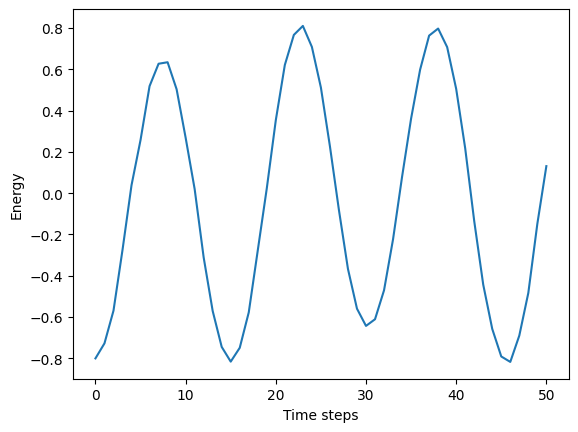

In [54]:
plt.plot(values)
plt.xlabel('Time steps')
plt.ylabel('Energy')

In [176]:
def dephasing_channel(circuit,qubit,ancilla,rot,reset = True):
    '''
    Based on https://arxiv.org/pdf/2209.11655
    '''
    #circuit.h(qubit)
    circuit.cry(rot,target_qubit = ancilla,control_qubit  = qubit)
    circuit.cx(target_qubit = qubit,control_qubit  = ancilla)
    #circuit.measure(ancilla)
    if reset:
        circuit.reset(ancilla)



In [150]:
backend = AerSimulator()
estimator = Estimator(backend)

observable = SparsePauliOp(['IZ'],coeffs=[1])

circuits=[]

circ = QuantumCircuit(2)
circ.ry(0.1,0)
circuits.append(circ.copy())

for step in np.arange(1,0,-0.01):
    circ = QuantumCircuit(2)
    circ.ry(0.1,0)
    dephasing_channel(circ,0,1,2*np.arccos(step))
    circuits.append(circ.copy())


#Define the observable
observables = [observable]*len(circuits)


# Get ISA circuits
pm = generate_preset_pass_manager(optimization_level=2, backend=backend)
pubs = []
for qc, obs in zip(circuits, observables):
    isa_circuit = pm.run(qc)
    isa_obs = obs.apply_layout(isa_circuit.layout)
    pubs.append((isa_circuit, isa_obs))


job = estimator.run(pubs)
job_result = job.result()


values = []
for idx in range(len(pubs)):
    pub_result = job_result[idx]
    values.append(float(pub_result.data.evs))


values = np.array(values)

Text(0, 0.5, 'Energy')

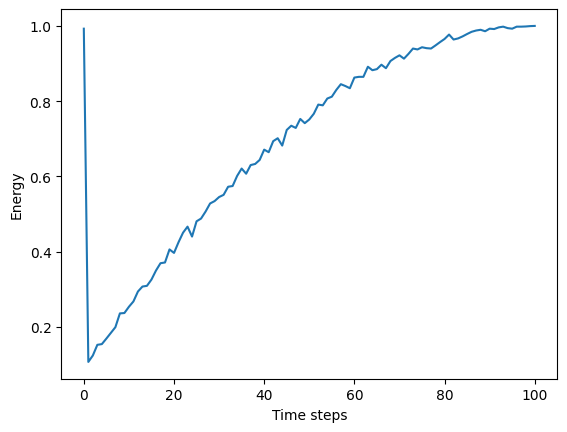

In [151]:
plt.plot(values)
plt.xlabel('Time steps')
plt.ylabel('Energy')

In [305]:
backend = AerSimulator(method="matrix_product_state")
estimator = Estimator(backend)


n_qubits = 7
ang_start = 0

circuits=[]
circ = QuantumCircuit(n_qubits)
for n in range(n_qubits-1):
    circ.ry(ang_start+n,n)
    
circuits.append(circ.copy())

for step in np.arange(1,0,-0.05):
    circ = QuantumCircuit(n_qubits)
    for n in range(n_qubits-1):
        circ.ry(ang_start+n,n)
        #circ.h(n)
        dephasing_channel(circ,n,n_qubits-1,2*np.arccos(step),reset = False)
        #circ.h(n)
        
    circ.reset(n_qubits-1)
    circuits.append(circ.copy())

res = []
for n in range(n_qubits):
    print(n)
    obi = ['I'] * (n_qubits)
    obi[n] = 'Z'
    obi = ''.join(obi)
    obi = SparsePauliOp(obi,coeffs=[1])

    #Define the observable
    observables = [obi]*len(circuits)

    # Get ISA circuits
    pm = generate_preset_pass_manager(optimization_level=2, backend=backend)
    pubs = []
    for qc, obs in zip(circuits, observables):
        isa_circuit = pm.run(qc)
        isa_obs = obs.apply_layout(isa_circuit.layout)
        pubs.append((isa_circuit, isa_obs))

    job= estimator.run(pubs)
    job_result = job.result()
    
    values = []
    for idx in range(len(pubs)):
        pub_result = job_result[idx]
        values.append(float(pub_result.data.evs))
    
    res.append(np.array(values))

0
1
2
3
4
5
6


Text(0, 0.5, 'Energy')

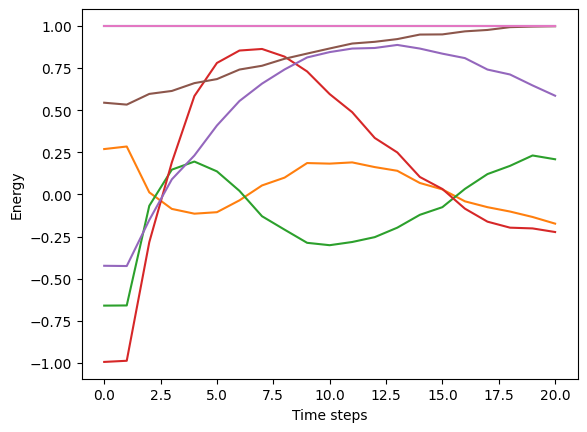

In [306]:
for r in res:
    plt.plot(r)
plt.xlabel('Time steps')
plt.ylabel('Energy')

In [220]:
print(circuits[-1])

     ┌───────┐              ┌───┐                                      »
q_0: ┤ Ry(2) ├──────■───────┤ X ├──────────────────────────────────────»
     ├───────┤      │       └─┬─┘              ┌───┐                   »
q_1: ┤ Ry(3) ├──────┼─────────┼────────■───────┤ X ├───────────────────»
     ├───────┤      │         │        │       └─┬─┘              ┌───┐»
q_2: ┤ Ry(4) ├──────┼─────────┼────────┼─────────┼────────■───────┤ X ├»
     ├───────┤      │         │        │         │        │       └─┬─┘»
q_3: ┤ Ry(5) ├──────┼─────────┼────────┼─────────┼────────┼─────────┼──»
     ├───────┤      │         │        │         │        │         │  »
q_4: ┤ Ry(6) ├──────┼─────────┼────────┼─────────┼────────┼─────────┼──»
     ├───────┤      │         │        │         │        │         │  »
q_5: ┤ Ry(7) ├──────┼─────────┼────────┼─────────┼────────┼─────────┼──»
     └───────┘┌─────┴──────┐  │  ┌─────┴──────┐  │  ┌─────┴──────┐  │  »
q_6: ─────────┤ Ry(3.0416) ├──■──┤ Ry(3.0416) ├──■─

In [291]:
backend = AerSimulator()
estimator = Estimator(backend)


n_qubits = 4
q_color = [n for n in range(n_qubits)]
q_ancilla = [len(q_color) + n for n in range(n_qubits)]
ang_start = [np.random.rand()*2*np.pi for q in q_color]
ang_end = [2 for q in q_color]
g = 2

circuits=[]

for step in np.arange(1,-0.1,-0.1):
    circ = QuantumCircuit(2 * n_qubits)
    for n,ang in enumerate(ang_start):
        circ.ry(ang,n)
        dephasing_channel(circ, q_color[n], q_ancilla[n], 2*np.arccos(step), reset = False)

    for _ in range(10):
        for q in q_ancilla[:-1]:
            circ.rxx(g, q, q + 1)
            circ.rx(g, q)

    for q in q_ancilla:
        circ.reset(q)
    
    circuits.append(circ.copy())

res = []
for n in range(2*n_qubits):
    print(n)
    obi = ['I'] * (2*n_qubits)
    obi[n] = 'Z'
    obi = ''.join(obi)
    obi = SparsePauliOp(obi,coeffs=[1])

    #Define the observable
    observables = [obi]*len(circuits)

    # Get ISA circuits
    pm = generate_preset_pass_manager(optimization_level=2, backend=backend)
    pubs = []
    for qc, obs in zip(circuits, observables):
        isa_circuit = pm.run(qc)
        isa_obs = obs.apply_layout(isa_circuit.layout)
        pubs.append((isa_circuit, isa_obs))

    job= estimator.run(pubs)
    job_result = job.result()
    
    values = []
    for idx in range(len(pubs)):
        pub_result = job_result[idx]
        values.append(float(pub_result.data.evs))
    
    res.append(np.array(values))

0
1
2
3
4
5
6
7


Text(0, 0.5, 'Energy')

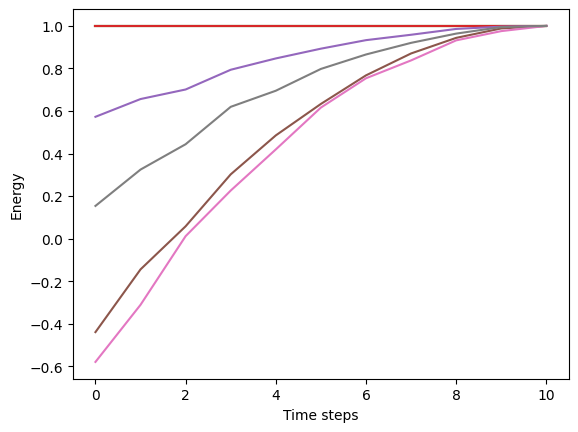

In [292]:
for r in res:
    plt.plot(r)
plt.xlabel('Time steps')
plt.ylabel('Energy')

In [290]:
print(circuits[-1])

      ┌────────────┐                                    ┌───┐               »
q_0: ─┤ Ry(4.3031) ├────■───────────────────────────────┤ X ├───────────────»
      ├────────────┤    │                               └─┬─┘┌───┐          »
q_1: ─┤ Ry(5.1424) ├────┼────────■────────────────────────┼──┤ X ├──────────»
      ├────────────┤    │        │                        │  └─┬─┘┌───┐     »
q_2: ─┤ Ry(2.6558) ├────┼────────┼────────■───────────────┼────┼──┤ X ├─────»
     ┌┴────────────┤    │        │        │               │    │  └─┬─┘┌───┐»
q_3: ┤ Ry(0.72431) ├────┼────────┼────────┼────────■──────┼────┼────┼──┤ X ├»
     └─────────────┘┌───┴───┐    │        │        │      │    │    │  └─┬─┘»
q_4: ───────────────┤ Ry(π) ├────┼────────┼────────┼──────■────┼────┼────┼──»
                    └───────┘┌───┴───┐    │        │           │    │    │  »
q_5: ────────────────────────┤ Ry(π) ├────┼────────┼───────────■────┼────┼──»
                             └───────┘┌───┴───┐    │            